# Analyzing Zebrafish 10hpf Embryo Stereo-seq Data with STpipe

Compiled: April 5, 2024

For this tutorial, we will be analyzing the a dataset of zebrafish 10hpf embryos freely available from stomics. There are 19102 single cells that were sequenced on the 
DNBSEQ-T1. The Stereo-seq data is from https://db.cngb.org/stomics/datasets/STDS0000057. Click on the "Data" tab, where you can find Stereo-seq and scrna-seq data for zebrafish 10hpf embryos. Both datasets have been analyzed, but we can demonstrate using the raw counts for further analysis.

## Import the required packages

In [2]:
import anndata
import stpipe as sp
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
from collections import OrderedDict

## Import the zebrafish Stereo-seq data

In [4]:
adata=anndata.read_h5ad('zf10_stereoseq.h5ad')

In [5]:
adata

AnnData object with n_obs × n_vars = 19102 × 18698
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seurat_clusters', 'spatial_x', 'spatial_y', 'slice', 'time_point', 'bin_annotation', 'colors', 'layer_annotation', 'layer_colors'
    layers: 'counts'

In [6]:
adata.X=adata.layers['counts']

In [7]:
adata.obs['slice'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26])

## Filter

You can use SpatialQC(https://github.com/mgy520/SpatialQC) to generate a quality control report. Let's continue.

In [8]:
adata=sp.filter_cells(adata,min_genes=1)
adata=sp.filter_genes(adata,min_cells=1)

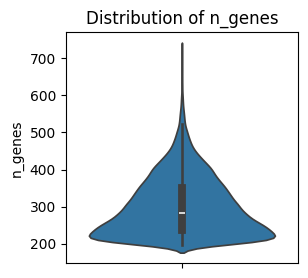

In [9]:
sp.violin(adata,feature='n_genes',fig_size=(3,3))

## Normalize

STpipe utilizes the global-scaling normalization method called "LogNormalize". This method normalizes the measured expression values of each feature in each cell by the total expression across all features, multiplying by a scaling factor (default is 10000), and then applying a logarithmic transformation to the result.

For scaling factor, you can refer to the maximum number of counts and try to avoid a gap of several orders of magnitude. This will affect subsequent differential expression gene analysis.

In [10]:
np.max(np.sum(adata.X, axis=1))

1983.0

In [11]:
adata=sp.lognormal(adata,scale_factor=2000)

## Find variable genes

STpipe uses the VST (Variance Stabilizing Transformation) algorithm to identify highly variable genes, similar to the Seurat in R.

In [12]:
adata=sp.vst_highly_variable_genes(adata,n_top_genes=2000)

In [13]:
adata

AnnData object with n_obs × n_vars = 19102 × 18698
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seurat_clusters', 'spatial_x', 'spatial_y', 'slice', 'time_point', 'bin_annotation', 'colors', 'layer_annotation', 'layer_colors', 'n_genes'
    var: 'n_cells', 'highly_variable', 'variances_norm', 'means'
    layers: 'counts'

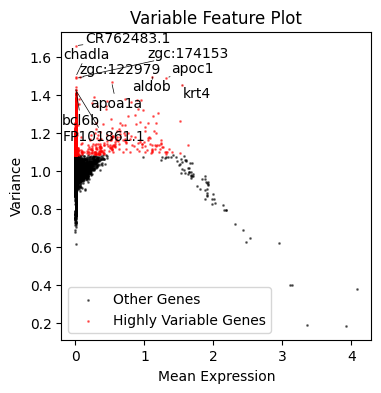

In [14]:
ranked_genes = np.argsort(adata.var['variances_norm'])[::-1]
top_genes = adata.var_names[ranked_genes[:10]]
sp.variable_plot(adata, log=False,figsize=(4,4),annotate_genes=top_genes)

## Scale

Next, we extract highly variable genes and then standardize the expression matrix to conform to a standard normal distribution with a mean of 0 and a variance of 1. This must be done before conducting PCA analysis.

In [16]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
adata=sp.scale(adata)

## PCA

Next we perform PCA on the scaled data. 

In [17]:
adata=sp.PCA(adata)

[pca] >A Python Package for Principal Component Analysis (https://github.com/erdogant/pca)
[pca] >Input data is a sparse matrix. Method is set to: [trunc_svd].
[pca] >The PCA reduction is performed on the [2000] columns of the input dataframe.
[pca] >Fit using Truncated SVD.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >done.


## Determine the PCs used for subsequent analysis.

The PCA variance selection Scree plot is a commonly used visualization tool to aid in determining how many principal components should be retained. This plot illustrates the proportion of variance explained by each principal component, typically showing a gradual decrease in variance explained proportion as the number of principal components increases. In the plot, a "bend point" or "knee" is often observed, indicating a sharp decline in the proportion of variance explained. This "knee point" is typically considered the appropriate position to select the number of principal components because it represents a significant change in the rate of decrease in explained variance proportion with the addition of more principal components. In the figure below, we select the first 15 PCs.

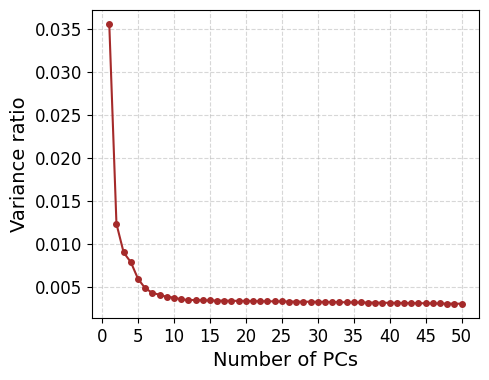

In [18]:
sp.pca_variance_ratio(adata,npc=50)

## TSNE

After PCA, t-SNE can be employed as a dimensionality reduction technique for further visualization and analysis. t-SNE is particularly useful for visualizing high-dimensional data in lower-dimensional space while preserving the local structure of the data points. 

In [19]:
adata = sp.tsne(adata, input=15,n_jobs=10)

[scatterd] >INFO> Precomputed initialization provided. Ignoring initalization-related parameters.
[scatterd] >INFO> Automatically determined negative gradient method `fft`
[scatterd] >INFO> Automatically determined negative gradient method `fft`


## Cluster

First, we construct a neighbor graph in the PCA space using the NearestNeighbors method to calculate the neighbors for each data point. The results are stored in adata.uns['neighbors'].

Next, we can directly utilize the Leiden clustering algorithm. The resolution parameter controls the granularity of the clustering, with higher values leading to more clusters.

In [20]:
adata=sp.find_neighbors(adata,n_components=15,n_neighbors=30)

In [24]:
adata = sp.leiden(adata,resolution=0.5)

In [25]:
adata.obs['leiden'].value_counts()

3    6928
2    4242
1    3991
0    3246
4     695
Name: leiden, dtype: int64

Plot the Leiden clustering on the t-SNE results.

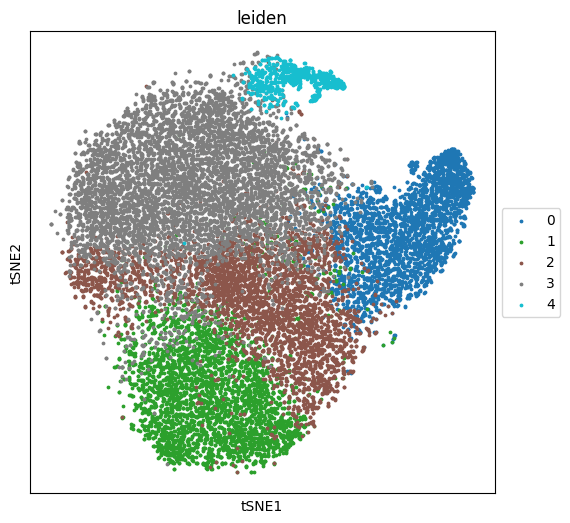

In [36]:
sp.plot_tsne(adata,by='leiden',cmap='tab10',s=3)

## Find markers

In the differential gene expression analysis step, log-normalized data for all genes is utilized.

In [28]:
adata = adata.raw.to_adata()

STpipe employs Welch's t-test and can utilize the findallmarkers function to identify marker genes for all clusters by comparing the current cluster with all other clusters.
You can also use the find_markers_between_groups function to identify differentially expressed genes between two clusters.

In [29]:
adata=sp.findallmarkers(adata,cluster_key='leiden',min_pct=0.1)

In [46]:
top_genes = {}
for cluster, df in adata.uns['markers_all'].items():
    top_genes_list = df.sort_values(by='pval', ascending=True)['gene'].head(10).tolist()
    top_genes[str(cluster)] = top_genes_list

all_top_genes = [gene for genes in top_genes.values() for gene in genes]

In [32]:
adata.layers['logcounts']=adata.X

In [33]:
adata=sp.scale(adata)

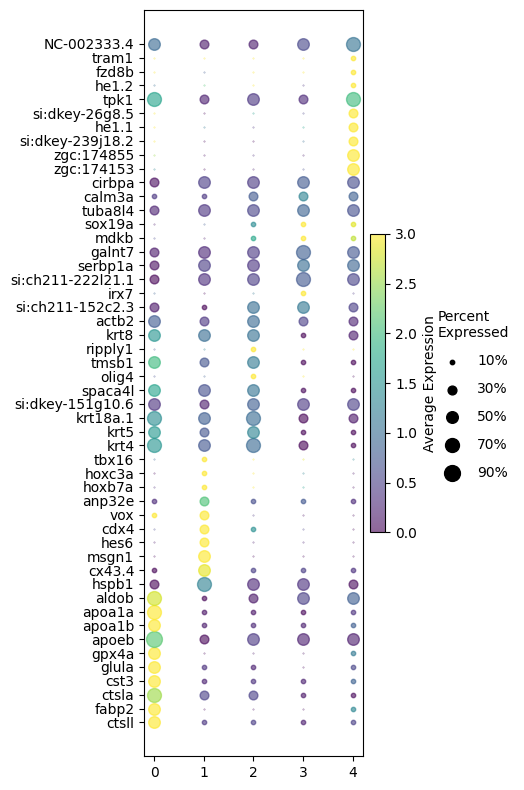

In [48]:
sp.plot_marker_dotplot(adata,groupby='leiden',genes=all_top_genes,figsize=(5,8))